<a href="https://colab.research.google.com/github/Anjasfedo/Learning-TensorFlow/blob/main/eat_tensorflow2_in_30_days/Chapter6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6-1 Three Ways of Modeling

There are three ways of modeling:
- Using `Sequential` to construct model with the order of layerr.
- Using functional APIs to construct model with arbitary structure.
- Using child class inheriting from base class `Model`.

For the models with sequenced structure, `Sequential` method should be given the highest priority.

For the models with non-sequential structure such as multiple input/output, shared weights, or resdual connections, modeling with functional API is recommended.

Modeling through child class of `Model` shoud be AVOIDE unless with special requirements. This method is flexible, but also fallible.

Here is the example of modeling using the three above-mentioned methods to classify IMDB movie reviews.

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tqdm import tqdm

In [18]:
!git clone https://github.com/lyhue1991/eat_tensorflow2_in_30_days.git

Cloning into 'eat_tensorflow2_in_30_days'...
remote: Enumerating objects: 14635, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14635 (delta 8), reused 8 (delta 4), pack-reused 14617
Receiving objects: 100% (14635/14635), 59.88 MiB | 22.53 MiB/s, done.
Resolving deltas: 100% (13241/13241), done.
Updating files: 100% (12529/12529), done.


In [28]:
train_token_path = "/content/eat_tensorflow2_in_30_days/data/imdb/train_token.csv"
test_token_path = "/content/eat_tensorflow2_in_30_days/data/imdb/test_token.csv"

In [29]:
MAX_WORDS = 10000 # only consider the top 10k words in the dataset
MAX_LEN = 200 # cut reviews after 200 words
BATCH_SIZE = 20

In [30]:
# Constructing data pipeline
def parse_line(line):
  t = tf.strings.split(line, sep="\t")
  label = tf.reshape(tf.cast(tf.strings.to_number(t[0]), tf.int32), (-1,))
  features = tf.cast(tf.strings.to_number(tf.strings.split(t[1], sep=" ")), tf.int32)
  return (features, label)

ds_train = tf.data.TextLineDataset(filenames=[train_token_path]) \
          .map(parse_line, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
          .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE)

ds_test = tf.data.TextLineDataset(filenames=[test_token_path]) \
          .map(parse_line, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
          .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE)

## 1. Modeling Using `Sequential`

In [31]:
tf.keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Embedding(MAX_WORDS, 7, input_length=MAX_LEN))
model.add(layers.Conv1D(filters=64, kernel_size=5, activation="relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 7)            70000     
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           2304      
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 48, 32)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 1536)              0

In [35]:
import datetime

logdir = "/content/data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=6,
                    callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2161 - accuracy: 0.9133 - auc: 0.9716 - val_loss: 0.3248 - val_accuracy: 0.8708 - val_auc: 0.9427
Epoch 2/6
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1247 - accuracy: 0.9535 - auc: 0.9902 - val_loss: 0.4521 - val_accuracy: 0.8600 - val_auc: 0.9305
Epoch 3/6
1000/1000 [==============================] - 22s 21ms/step - loss: 0.0601 - accuracy: 0.9786 - auc: 0.9976 - val_loss: 0.6357 - val_accuracy: 0.8556 - val_auc: 0.9185
Epoch 4/6
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0239 - accuracy: 0.9922 - auc: 0.9996 - val_loss: 0.9201 - val_accuracy: 0.8502 - val_auc: 0.9052
Epoch 5/6
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0117 - accuracy: 0.9958 - auc: 0.9999 - val_loss: 1.1740 - val_accuracy: 0.8476 - val_auc: 0.8968
Epoch 6/6
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0159 - accuracy: 0.9940 - auc: 0.999

In [36]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
  train_metrics = history.history[metric]
  val_metrics = history.history['val_'+metric]
  epochs = range(1, len(train_metrics) + 1)
  plt.plot(epochs, train_metrics, 'bo--')
  plt.plot(epochs, val_metrics, 'ro-')
  plt.title('Training and validation '+ metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(["train_"+metric, 'val_'+metric])
  plt.show()

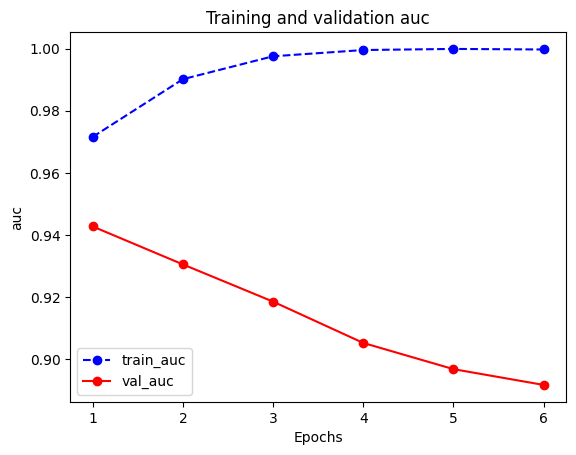

In [40]:
plot_metric(history,"auc")